# Importance Sampling

Alex Gorodetsky,
Initial: September, 2020
Updated: January, 2024


In [1]:
%matplotlib widget
from typing import Tuple, Callable
from dataclasses import dataclass

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
# Sympy Stuff
import sympy

from montecarlo import monte_carlo, MonteCarloEstimate

## Rare event estimation

Importance sampling is often used to increase the feasibility of rare-event estimation. It is also commonly used for variance reduction, here we will see how these two aspects are related.

Consider a standard normal random variable $Z \sim \mathcal{N}(0, 1).$ We would like to evaluate $P_Z(Z > 4.5).$ We first obtain the analytic solution to demonstrate the challenge

\begin{equation}
P*Z(Z > 4.5) = \int*{4.5}^{\infty} \frac{1}{\sqrt{2 \pi}} \exp\left(-\frac{1}{2} z^2 \right) dz = \mathbb{E}\left[ \mathbf{1}_{Z > 4.5}\right]
\end{equation}


In [3]:
xs = sympy.Symbol('xs')
fz = sympy.exp(-xs**2/2)/sympy.sqrt(2 * np.pi)
Pz = sympy.integrals.integrate(fz, (xs, 4.5, sympy.oo)).evalf()
print("Analytic solution: ")
print(Pz)

Analytic solution: 
3.39767312476808e-6


### Monte Carlo

First we try Monte Carlo with M=10000 samples


In [4]:
M = 100000
sampler = np.random.randn


def gfunc(x: np.ndarray) -> np.ndarray:
    return x > 4.5


Pz_mc = monte_carlo(M, sampler, gfunc)
print("Monte Carlo Estimate with {:d} samples = {:5E}\n\t Truth = {:5E}".format(
    M, Pz_mc.estimate, Pz))

Monte Carlo Estimate with 100000 samples = 0.000000E+00
	 Truth = 3.39767312476808E-6


### Importance Sampling

Next we try importance sampling with a proposal distribution that is a shifted exponential random variable located at $x=4.5$ with scale = 1. $$ \pi(z) \propto \exp(-(z-4.5)) $$


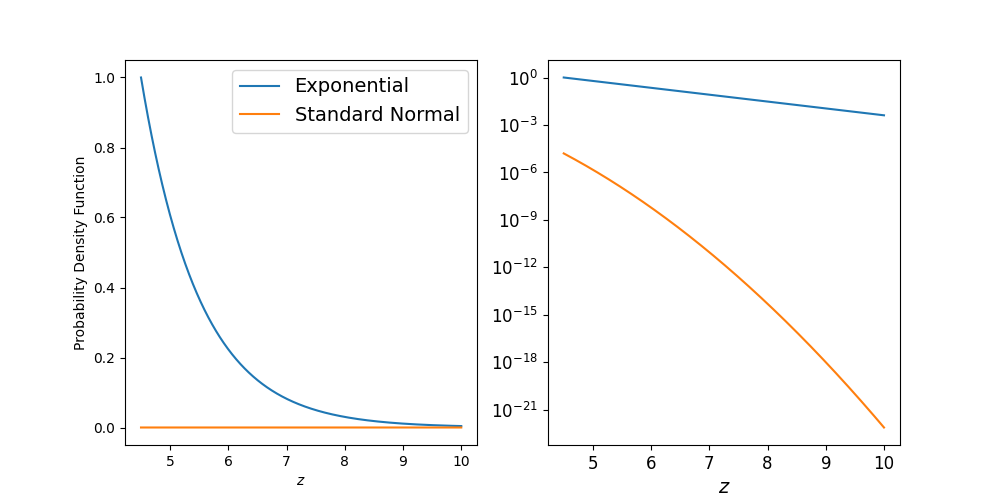

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
x = np.linspace(4.5, 10, 1000)
# print("x = ", x)
y = stats.expon.pdf(x, loc=4.5)
yn = stats.norm.pdf(x)
ax1.plot(x, y, label='Exponential')
ax1.plot(x, yn, label='Standard Normal')
ax1.legend(fontsize=14)
ax1.set_xlabel(r'$z$')
ax1.set_ylabel("Probability Density Function")
ax2.semilogy(x, y, label='Exponential')
ax2.semilogy(x, yn, label='Standard Normal')
ax2.set_xlabel(r'$z$', fontsize=14)

plt.show()

Now lets create an importance sampling estimate


In [6]:
@dataclass
class ImportanceSamplingEstimate:
    mc: MonteCarloEstimate
    weights: np.ndarray


def importance_sampling(num_samples: int,
                        proposal_sample_generator: Callable[[int], np.ndarray],
                        proposal_pdf_evaluator: Callable[[np.ndarray], np.ndarray],
                        base_pdf_evaluator: Callable[[np.ndarray], np.ndarray],
                        g_evaluator: Callable[[np.ndarray], np.ndarray]) -> ImportanceSamplingEstimate:
    """Perform importance sampling.

    Note that the code is basically the same as Monte Carlo, but with a set of weights.

    Args:

        num_samples: number of samples
        proposal_sample_generator: A function that generates samples with signature sample_generator(nsamples)
        proposal_pdf_evaluator: evaluate the pdf of the proposal.
        base_pdf_evaluator: evaluate the pdf of the underlying random variable.
        g_evaluator: a function that takes as inputs the samples and outputs the evaluations.
                     The outputs can be any dimension, however the first dimension should have size *num_samples*

    Returns:

        An importance sampling estimator.
    """
    samples = proposal_sample_generator(num_samples)
    weights = base_pdf_evaluator(samples) / proposal_pdf_evaluator(samples)
    evaluations = g_evaluator(samples)
    estimate = np.sum(evaluations * weights, axis=0) / float(num_samples)

    ret = ImportanceSamplingEstimate(MonteCarloEstimate(
        estimate, samples, evaluations), weights)
    return ret

Now lets apply this to the rare event sampler


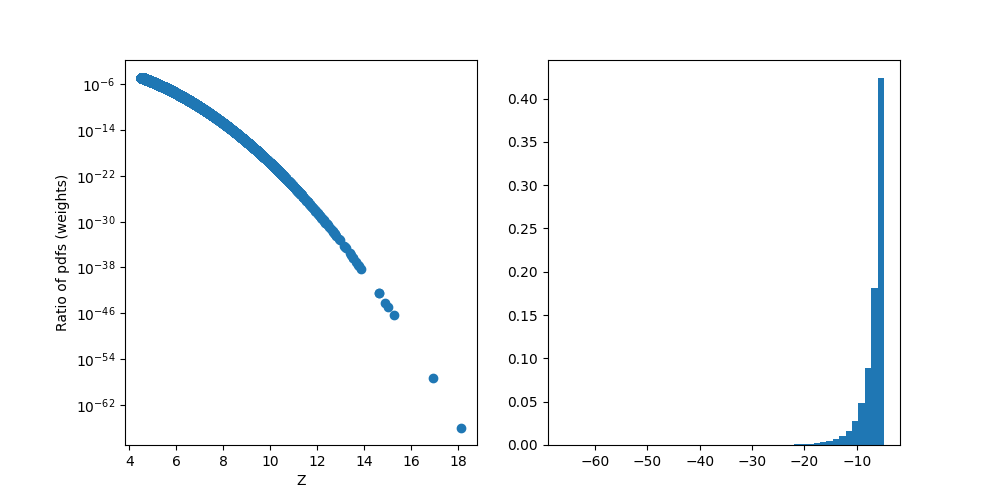

Importance Sample Estimate with 100000 samples = 3.394946E-06
	 Truth = 3.39767312476808E-6


In [7]:
def proposal_sampler(n: int) -> np.ndarray:
    return stats.expon.rvs(size=n, loc=4.5)  # illegal in the project


def proposal_pdf(x: np.ndarray) -> np.ndarray:
    return stats.expon.pdf(x, loc=4.5)


def base_pdf(x: np.ndarray) -> np.ndarray:
    return stats.norm.pdf(x)


Pz_is = importance_sampling(M, proposal_sampler, proposal_pdf, base_pdf, gfunc)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# plot the normalized weights
ax1.semilogy(Pz_is.mc.samples, Pz_is.weights, 'o')
ax1.set_xlabel("Z")
ax1.set_ylabel("Ratio of pdfs (weights)")
ax2.hist(np.log10(Pz_is.weights, Pz_is.weights + 1e-20), bins=50, density=True)
plt.show()

print("Importance Sample Estimate with {:d} samples = {:5E}\n\t Truth = {:5E}".format(
    M, Pz_is.mc.estimate, Pz))

### A look at the variance

Recall that the event $Z>4.5$ is a Bernoulli random variable with probability $p$
\begin{equation}
I\_{Z>4.5}(z) = \left\{
\begin{array}{cc}
1 & \text{ if } z > 4.5 \\
0 & \text{ otherwise}
\end{array}
\right.
\end{equation}
where $p \equiv P(Z > 4.5) \approx 3.39767312476808 \times 10^{-6}.$ The variance of this random variable is $p(1-p)$, which is very small and the standard error is $\sigma = \sqrt{p(1-p)/N}$


In [8]:
import math
sigma = math.sqrt(Pz*(1-Pz)/M)
sigma

5.828946371845786e-06

This number is very small, which might seem good. However, in practice we want to obtain small relative errors with respect to the true value. In this case the true value is $p$, and this means that we want $\sigma = \sqrt{\frac{p(1-p)}{M}} = \mathcal{O}(\epsilon p)$ for relative error tolerances $\epsilon$. To see if this is reasonable for Monte Carlo lets look at how many sample we would require to obtain a 10% error, or $\epsilon=0.1$


In [9]:
epsilon = 0.1
required_m = (Pz * (1 - Pz)) / (epsilon * Pz)**2
required_m

29431807.1693590

Thats way too much! Lets look at the (approximate) variance of importance sampler. Here we are looking at $\mathbb{V}\textrm{ar}\left[I_{Z>4.5}(x)w(x)\right]$


In [10]:
# Note this is just an estimate!!
# again the indicator function is missing because all samples above it
var_is = np.var(Pz_is.weights)
var_is
print(np.sqrt(var_is))

4.41113693434234e-06


This number is much smaller and more reasonable! We can now determine the required number of samples for importance sampling


In [11]:
required_m_is = var_is / (epsilon * Pz)**2
required_m_is

168.553544429520

This is far more reasonable!


## Optimal proposal

In practice, it is quite difficult to analytically determine how good your proposal distribution is, and diagnostics need to be developed.

Before we consider a diagnostic, recall that the optimal proposal is given by
\begin{equation}
q^\*\_X(x) = \frac{|g(x)|f_X(x)}{\int |g(x)|f_X(x) dx}
\end{equation}

The denominator is a constant (lets call it $Z$) so that this equation states
\begin{equation}
Z = \frac{|g(x)|f_X(x)}{q^\*\_X(x)}
\end{equation}
In other words, we want the given ratio of be fairly constant, so that the proposal is large where the product of $g$ and $f_X$ is large.

This optimal proposal is difficult to compute in practice because it requires knowing this normalizing constant, a computational task that is as difficult as solving the original problem.

But in this problem lets look at what it looks like


In [12]:
xs = sympy.Symbol('xs')
num = sympy.exp(-xs**2/2)/sympy.sqrt(2 * np.pi)
den = sympy.integrals.integrate(fz, (xs, 4.5, sympy.oo)).evalf()
opt_proposal = num / den
print("Optimal proposal = ", opt_proposal)
opt_prop_numeric = sympy.lambdify((xs), opt_proposal)

Optimal proposal =  117416.321627074*exp(-xs**2/2)


Now lets compare this optimal proposal with what we used before


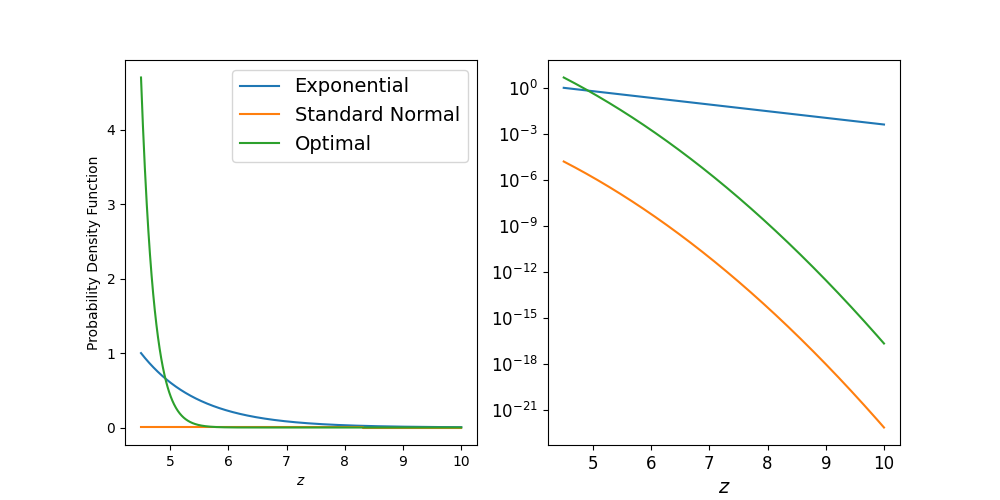

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
x = np.linspace(4.5, 10, 1000)
# print("x = ", x)
y = stats.expon.pdf(x, loc=4.5)
yn = stats.norm.pdf(x)
yopt = opt_prop_numeric(x)
ax1.plot(x, y, label='Exponential')
ax1.plot(x, yn, label='Standard Normal')
ax1.plot(x, yopt, label="Optimal")
ax1.legend(fontsize=14)
ax1.set_xlabel(r'$z$')
ax1.set_ylabel("Probability Density Function")
ax2.semilogy(x, y, label='Exponential')
ax2.semilogy(x, yn, label='Standard Normal')
ax2.plot(x, yopt, label="Optimal")
ax2.set_xlabel(r'$z$', fontsize=14)

plt.show()

We see that the tail behavior is much loser aligned to that of a Gaussian. Lets now take a look at the distribution of the weights and the answer


In [14]:
opt_prop_cdf = sympy.integrals.integrate(opt_proposal, (xs, 4.5, xs))
u = sympy.Symbol('u')  # define a symbol for the inverse
opt_prop_cdf_inv = sympy.solve(opt_prop_cdf - u, xs)
print("Inverse CDF = ", opt_prop_cdf_inv)

Inverse CDF =  [1.4142135623731*erfinv(6.79534624953615e-6*u + 0.999993204653751)]


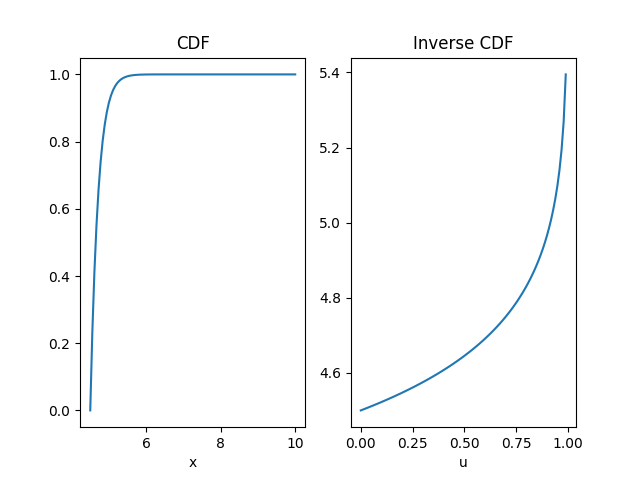

In [15]:
opt_prop_cdf_numeric = sympy.lambdify((xs), opt_prop_cdf)
opt_prop_inv_cdf_numeric = sympy.lambdify((u), opt_prop_cdf_inv)
fig, axs = plt.subplots(1, 2)
xx = np.linspace(4.5, 10, 100)
axs[0].plot(xx, opt_prop_cdf_numeric(xx))
axs[0].set_xlabel("x")
axs[0].set_title("CDF")
uu = np.linspace(0, 1, 100)
xu = opt_prop_inv_cdf_numeric(uu)[0]
axs[1].plot(uu, xu)
axs[1].set_xlabel("u")
axs[1].set_title("Inverse CDF")
plt.show()

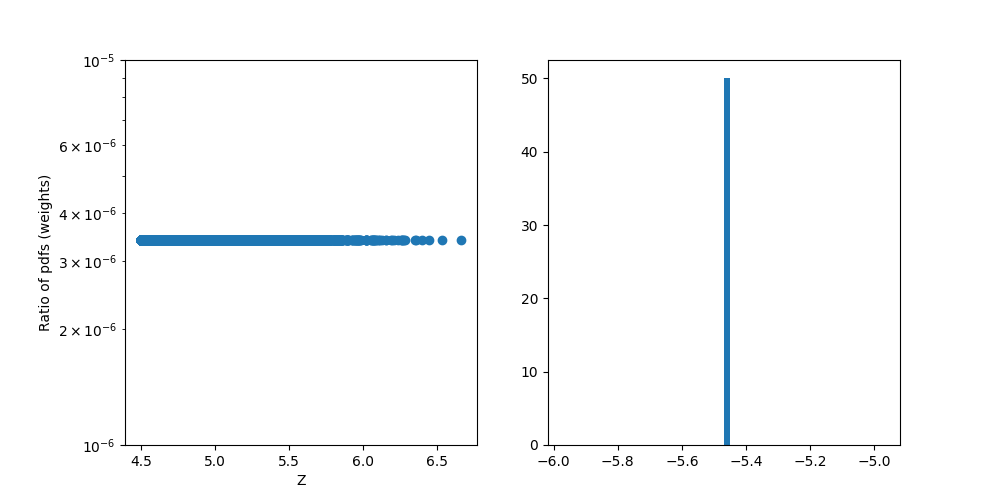

Importance Sample Estimate with 100000 samples = 3.397673E-06
	 Truth = 3.39767312476808E-6


In [16]:
def opt_proposal_sampler(n: int) -> np.ndarray:
    uu = np.random.rand(n)
    x = opt_prop_inv_cdf_numeric(uu)[0]
    return x


Pz_is_opt = importance_sampling(
    M, opt_proposal_sampler, opt_prop_numeric, base_pdf, gfunc)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.semilogy(Pz_is_opt.mc.samples, Pz_is_opt.weights,
             'o')  # plot the normalized weights
ax1.set_xlabel("Z")
ax1.set_ylabel("Ratio of pdfs (weights)")
ax2.hist(np.log10(Pz_is_opt.weights, Pz_is_opt.weights + 1e-20),
         bins=50, density=True)
plt.show()

print("Importance Sample Estimate with {:d} samples = {:5E}\n\t Truth = {:5E}".format(
    M, Pz_is_opt.mc.estimate, Pz))

**Wow this is amazing. All the weights are identical and we obtain the truth perfectly.**


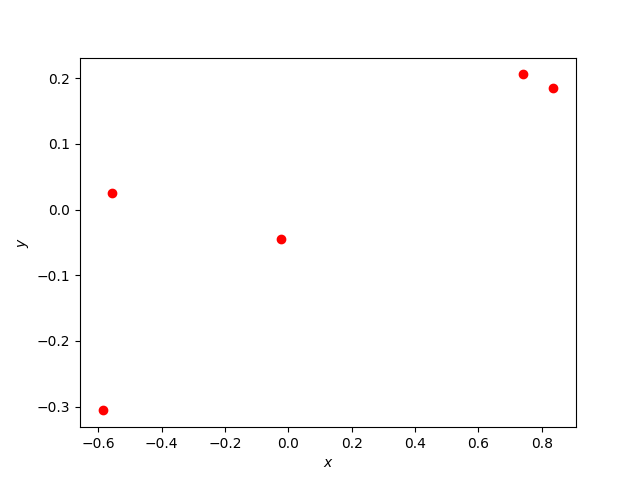

In [17]:
def get_data(ndata: int,
             noise_std: float = 0.1,
             true_param: float = 0.2,
             true_offset: float = 0.0) -> Tuple[np.ndarray, np.ndarray]:
    """Our observer of the world, we request a number of data points and it returns noisy measurements of the data"""
    np.random.seed(5)  # for reproducibility
    x = np.random.rand(ndata)*2.0 - 1.0  # [uniform on [-1,1]]
    true_y = true_param * x + true_offset  # y = mx + b
    noise = np.random.randn(ndata)*noise_std
    measured_y = true_y + noise
    return x, measured_y


OFFSET = 0.0
TRUE_PARAM = 0.2
DATAX, DATAY = get_data(5, true_param=TRUE_PARAM, true_offset=OFFSET)
plt.figure()
plt.plot(DATAX, DATAY, 'ro')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

We are primarily interested in predicting the function $g(x; \theta)$ at arbitrary values of $x.$ However, since we don't know $\theta$, we need to learn it first. We treat it as a random variable $\Theta$ and learning is defined as computing a probability distribution $P_{\Theta}(\theta \in d\theta \mid \mathcal{D})$; the probability distribution over the parameters given the data.

This distribution is obtained with Bayes rule. We write Bayes rule in probability density form as
\begin{equation}
f*{\Theta \mid \mathcal{D}}(\theta \mid \mathcal{D}) = \frac{1}{f*{\mathcal{D}}(\mathcal{D})} f*{\mathcal{D} \mid \Theta} (\mathcal{D} \mid \theta) f*{\Theta}(\theta)
\end{equation}

1. $f_{\Theta}$: the prior distribution, we will use a standard normal
2. $f_{\mathcal{D} \mid \Theta}$: the likelihood, we will assume the data points are independent and corrupted by Gaussian noise with a small standard deviation
   \begin{equation}
   f*{\mathcal{D} \mid \Theta}(\mathcal{D} \mid \theta) = \prod*{i=1}^n f*{Y\mid \Theta}(y^{(i)} \mid \theta, x^{(i)}) = \prod*{i=1}^n \mathcal{N}(y^{(i)}; x^{(i)}\theta, \sigma^2) = \prod\_{i=1}^n\left(\frac{1}{\sqrt{2\pi} \sigma} \exp\left(-\frac{1}{2\sigma^2}\left(y^{(i)} - x^{(i)} \theta\right)^2 \right)\right)
   \end{equation}
3. $f_{\Theta}(\theta \mid \mathcal{D})$: the posterior, it summarizes the information about the parameter that we learned from the data
4. $f_{\mathcal{D}}$: the evidence, in general we cannot compute this (it is as hard as the underlying problem, if not harder)

\begin{equation}
f*{\mathcal{D}}(\mathcal{D}) = \int f*{\mathcal{D} \mid \Theta} (\mathcal{D} \mid \theta) f\_{\Theta}(\theta) d\theta
\end{equation}

Because we cannot compute the normalizing factor (in this particular example, we actually could -- see if you can work it out), we can only evaluate the posterior up to a normalizing factor
\begin{equation}
f*{\Theta \mid \mathcal{D}}(\theta \mid \mathcal{D}) \propto f*{\mathcal{D} \mid \Theta} (\mathcal{D} \mid \theta) f\_{\Theta}(\theta)
\end{equation}

Finally, our goal is to predict $g(x)$, since $\theta$ is uncertain we will look at the expectation and variance of the predictions
\begin{equation}
\mathbb{E}\left[g(x, \Theta)\right] = \int g(x; \theta) f*{\Theta}(\theta \mid \mathcal{D}) d\theta = \int x \theta f*{\Theta}(\theta \mid \mathcal{D}) d\theta = x \mathbb{E}_{f_{\Theta}(\theta \mid \mathcal{D})} \left[\Theta\right]
\end{equation}
For the variance a straightforward calculation will yield
\begin{equation}
\mathbb{V}\text{ar}\left[g(x, \Theta)\right] = x^2\mathbb{V}\text{ar}_{f_{\Theta}(\theta \mid \mathcal{D})} \left[\Theta\right]
\end{equation}

We now use self-normalized importance sampling to solve this problem.

_Note we do this because we pretend like we cannot compute $Z$ in closed form here. (BTW because this problem is linear and uses Gaussian distributions, it actually does have an analytic solution. The posterior is Gaussian and we will cover this in great depth later on. However, for nonlinear problems this example holds._


In [18]:
def prior(param: np.ndarray) -> np.ndarray:
    """Standard Normal Gaussian prior"""
    pdf = stats.norm.pdf(param)
    return pdf


def likelihood(x: np.ndarray,
               y: np.ndarray,
               param: np.ndarray,
               sigma: float = 0.1) -> np.ndarray:
    """Gaussian likelihood assuming independent observations"""
    like = np.prod([stats.norm.pdf((yy-param*xx), scale=sigma)
                   for yy, xx in zip(y, x)])
    return like


def unnormalized_posterior(x: np.ndarray,
                           y: np.ndarray,
                           param: np.ndarray) -> np.ndarray:
    """The unnormalized posterior, simply a product of the prior and the likelihood"""
    return prior(param) * likelihood(x, y, param)

### The prior

The prior distribution represents our belief prior to seeing data


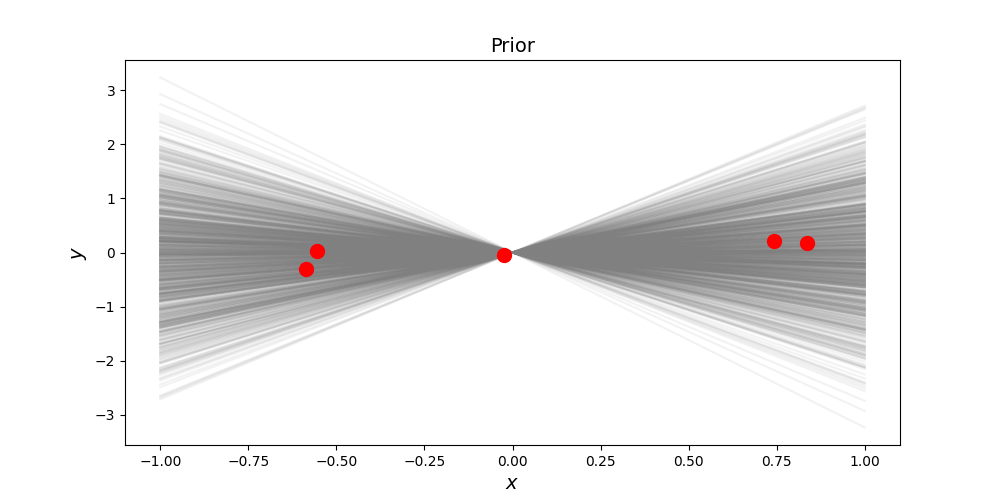

In [19]:
def plot_prior(datax: np.ndarray, datay: np.ndarray) -> None:
    xplot = np.linspace(-1, 1, 100)
    plt.figure(figsize=(10, 5))
    for ii in range(1000):
        plt.plot(xplot, np.random.randn()*xplot, color='grey', alpha=0.1)
    plt.plot(datax, datay, 'ro', ms=10)
    plt.title("Prior", fontsize=14)
    plt.xlabel(r'$x$', fontsize=14)
    plt.ylabel(r'$y$', fontsize=14)
    plt.show()


plot_prior(DATAX, DATAY)

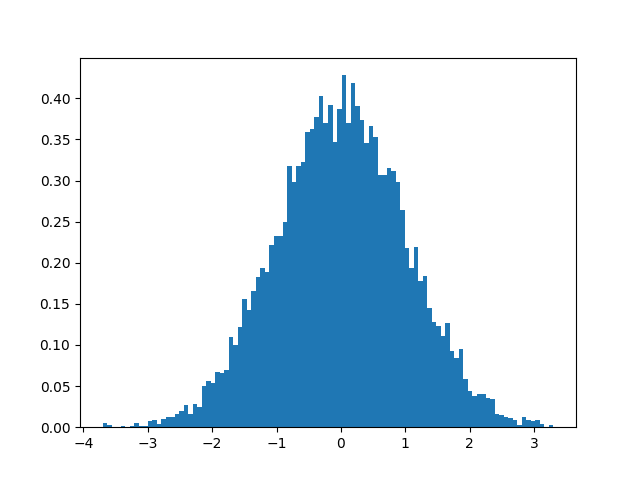

In [20]:
def plot_student_t(df: float = 1000):
    """Plot a student T histogram.

    Args:

        df: positive number is a parameter of the student t distribution (0, \infty)

    """
    plt.figure()
    plt.hist(stats.t.rvs(df, size=10000), bins=100, density=True)
    plt.show()


plot_student_t()

We now set up the self normalized importance sampling scheme


In [21]:
def self_normalized_is(num_samples: int,
                       sample_generator: Callable[[int], np.ndarray],
                       g_evaluator: Callable[[np.ndarray], np.ndarray],
                       w_evaluator: Callable[[np.ndarray], np.ndarray]):
    """Perform Self Normalized Importance Sampling

    Inputs
    ------
    num_samples: integer, number of samples
    sample_generator: A function that generates samples with signature sample_generator(nsamples)
    g_evaluator: A function that takes as inputs the samples and outputs the evaluations. 
                 The outputs can be any dimension (noutputs), however the first dimension should have size *num_samples*
    w_evaluator: A function that takes as inputs samples and returns un-normalized weights
                 the weights should be (num_samples)

    Returns
    -------
    estimate: a self normalized importance sampling estiamte of the expectation
    samples: the samples generated
    evaluations: evaluations of the function g
    normalized_weights: the weights used in the importance sampler
    """
    samples = sample_generator(num_samples)
    evaluations = g_evaluator(samples)
    weights = w_evaluator(samples)
    sum_weights = np.sum(weights)
    normalized_weights = weights / sum_weights
    estimate = np.dot(evaluations.T, normalized_weights)
    return estimate, samples, evaluations, normalized_weights

We now use self normalized importance sampling to solve the problem


In [22]:
nsamples_posterior = 1000
df = 1000
xpred = 0.5  # location at which to predict
def gfunc(param): return param * xpred
# need a weight to return a vectorized version of the unnormalized posterior
def un_norm_post(param): return np.array(
    [unnormalized_posterior(DATAX, DATAY, p) for p in param])


def weight_func(param): return un_norm_post(param) / stats.t.pdf(param, df)


def sampler(N): return stats.t.rvs(df, size=N)

Now we generate the samples and see what the prediction is: Recall that the truth is


In [23]:
0.2 * xpred

0.1

In [24]:
estimate, samples, evaluations, normalized_weights = self_normalized_is(
    nsamples_posterior, sampler, gfunc, weight_func)
print("Expected result: ", estimate)

Expected result:  0.12446258383977914


Pretty close, but lets see what is happening. The really nice thing about importance sampling is that you can reuse the samples for all sorts of different $g(X)$ functions! In this case all the different functions will come from choosing to predict at different locations $x \in [-1,1]$


In [25]:
def predict_mean_variance_for_all_x(samples, weights):
    """Predict the mean and variance of the function at all locations x

    We reuse the samples and weights to first compute two functions
    posterior mean = E[slope|data]
    posterior variance = Var(slope|data)

    Then we use the analytical expressions for the mean and variance that
    were derived above. It relies on the fact that the x\theta is linear in \theta

    """

    # posterior mean and variance of the parameters
    posterior_mean = np.dot(samples.T, weights)
    posterior_variance = np.dot((samples - posterior_mean)**2, weights)
    x = np.linspace(-1, 1, 100)

    # posterior mean and variance of g(x) at all locations x
    # for general function the predicted mean would be M = np.dot(g(samples), weights)
    # for general function the predicted variance would be np.dot((g(samples) - M)**2, weights)
    pred_mean = posterior_mean * x
    pred_var = posterior_variance * x**2
    return x, pred_mean, pred_var

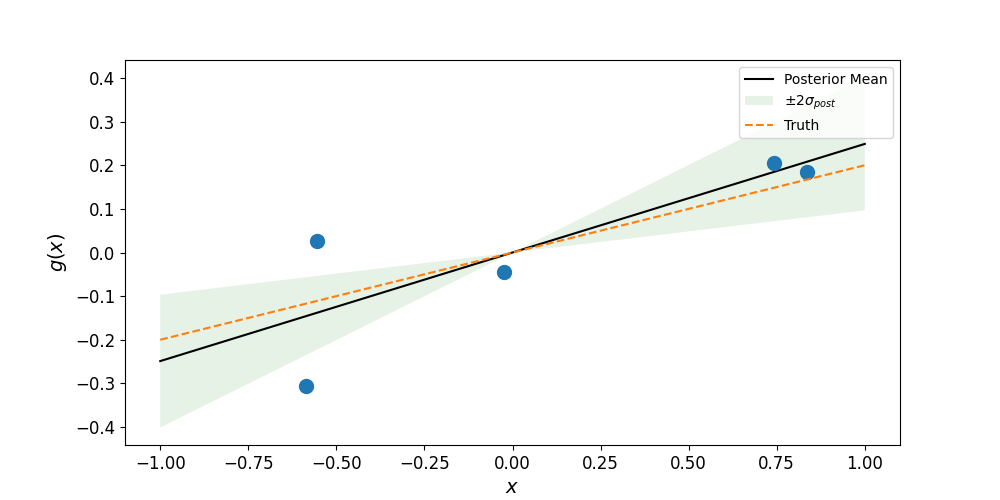

In [26]:
x, pred_mean, pred_var = predict_mean_variance_for_all_x(
    samples, normalized_weights)
# Plot the posterior mean += 2 standard deviation for the function
plt.figure(figsize=(10, 5))
plt.plot(x, pred_mean, '-', color='black', label='Posterior Mean')
y1 = (pred_mean - 2*np.sqrt(pred_var))
y2 = (pred_mean + 2*np.sqrt(pred_var))
plt.fill_between(x, y1, y2,
                 facecolor='green', interpolate=True, alpha=0.1,
                 label=r'$\pm 2 \sigma_{post}$')
plt.plot(DATAX, DATAY, 'o', ms=10)
plt.plot(x, OFFSET+TRUE_PARAM * x, '--', label='Truth')
plt.legend()
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$g(x)$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Pretty good fit, and it recognizes that there is uncertainty in the predictions.

Lets take a look at the Effective Sample Size


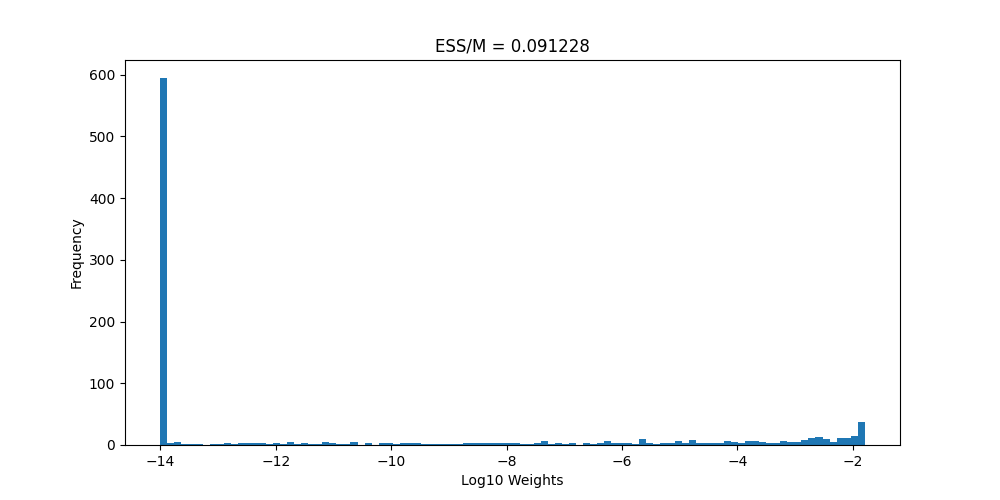

In [27]:
# Plot a Histogram of the effective sample size
plt.figure(figsize=(10, 5))
ESS = 1.0 / np.sum(normalized_weights**2)
plt.hist(np.log10(normalized_weights+1e-14),
         bins=100)  # added 1e-14 to avoid 0
plt.title("ESS/M = {:5f}".format(ESS/nsamples_posterior))
plt.xlabel('Log10 Weights', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

A large amount of samples have essentially zero weight! This is indicative of a poor proposal. We see that essentially only one out of every 10 samples "counts." The problem with this proposal is it is not focused into the actual region of high posterior probability. Later in class we will see how Markov Chain Monte Carlo (MCMC) methods attempt to rectify this situation
